In [1]:
#uncomment all lines below in this cell to replicate my installation on colab

!pip install qeds fiona geopandas xgboost gensim folium pyLDAvis descartes psaw pyarrow
!apt-get install libproj-dev proj-data proj-bin  
!apt-get install libgeos-dev  
!pip install cython  
!pip install cartopy 
!brew install proj geos
!pip3 uninstall shapely
!pip3 install --upgrade cython numpy pyshp six
!pip3 install shapely --no-binary shapely
!pip3 install git+https://github.com/SciTools/cartopy.git --no-binary cartopy

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libproj-dev is already the newest version (4.9.3-2).
proj-bin is already the newest version (4.9.3-2).
proj-data is already the newest version (4.9.3-2).
0 upgraded, 0 newly installed, 0 to remove and 31 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libgeos-dev is already the newest version (3.6.2-1build2).
0 upgraded, 0 newly installed, 0 to remove and 31 not upgraded.
/bin/bash: brew: command not found
Uninstalling Shapely-1.7.0:
  Would remove:
    /usr/local/lib/python3.6/dist-packages/Shapely-1.7.0-py3.6.egg-info
    /usr/local/lib/python3.6/dist-packages/shapely/*
Proceed (y/n)? y
  Successfully uninstalled Shapely-1.7.0
Requirement already up-to-date: cython in /usr/local/lib/python3.6/dist-packages (0.29.18)
Requirement already up-to-date: numpy in /usr/local/lib/python3.6/dist-packages (1.18.4)
Requirement already up-to

In [0]:
import pandas as pd 
import os
import IPython

import json
with open("to_from_data.json", "r") as read_file:
    rankings = json.load(read_file)
data = pd.DataFrame(rankings)

In [0]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

import qeds
qeds.themes.mpl_style();

import cartopy.crs as ccrs #cartopy documentation: https://scitools.org.uk/cartopy/docs/latest/
import cartopy.feature as cfeature

#import geopandas as gpd
#from shapely.geometry import Point

In [0]:
inst_data = pd.read_json("to_from_data.json") #set directory as necessary

In [0]:
inst_data["startdate"] = pd.to_datetime(inst_data["startdate"]) #convert object to datetime

In [6]:
inst_data.name.unique().shape #note 33 unique categories, names

(33,)

In [7]:
inst_data.description.unique() #note 10 unique recruiter_types, descriptions

array(['Academic organization (economics department)',
       'Private (non-profit) business or organization',
       'Academic organization (agricultural/resource economics department)',
       'Academic organization (business school)',
       'Academic organization (other than econ, business, or ag econ)',
       'Government agency or commission', 'Other type of organization',
       'Private (for profit) business or organization',
       'Human Resources department of educational or non-profit institution',
       'Advertising agency or executive recruiter'], dtype=object)

In [8]:
import nltk
nltk.download("punkt")

def desc_reviser(string):
    string = string.lower()
    tokens = [i for i in nltk.tokenize.word_tokenize(string)]
    return(tokens)

#desc_reviser(inst_data.description[6])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [0]:
desc_tokens = [desc_reviser(i) for i in inst_data.description]
inst_data["desc_tokens"] = desc_tokens

In [10]:
inst_data["revised_description"] = 0

for i in inst_data.index:
    if "academic" in inst_data.desc_tokens[i]:
        inst_data.revised_description[i] = inst_data.description[i]
        
    elif "government" in inst_data.desc_tokens[i]:
        inst_data.revised_description[i] = inst_data.description[i]
        
    elif "private" or "other" in inst_data.desc_tokens[i]:
        inst_data.revised_description[i] = "Private business or organization; Other type of organization"
        
    else: inst_data["revised_description"][i] = np.nan

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/

In [0]:
inst_data['revised_recruiter_hash'] = inst_data.revised_description.map(hash) #create column of revised recruiter types

In [0]:
inst_data["from_coordinates"] = list(zip(inst_data.longitude, inst_data.latitude))
inst_data["to_coordinates"] = list(zip(inst_data.to_longitude, inst_data.to_latitude))

In [0]:
data_subsets = {}
for i in inst_data.category_id.unique():
    inst_data_subset_iteration = inst_data[inst_data.category_id == i]
    data_subsets[i] = inst_data_subset_iteration

In [14]:
!pip install seaborn-qqplot

In [15]:
import seaborn as sns
import statsmodels.formula.api as smf
import scipy.stats as st
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.diagnostic import het_white
import statsmodels
import seaborn_qqplot as sqp
import statsmodels.discrete.discrete_model as sm

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


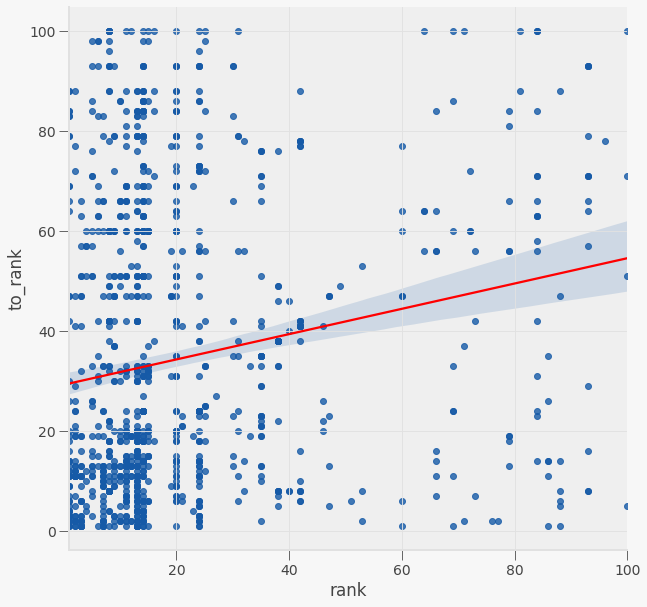

In [16]:
data_clean_rank = inst_data.dropna(subset = ["rank", "to_rank"])
fig, ax = plt.subplots(figsize = (10, 10))
rank_scat = sns.regplot(x = "rank", y = "to_rank", data = data_clean_rank, ax = ax)
rank_scat.get_lines()[0].set_color("red")

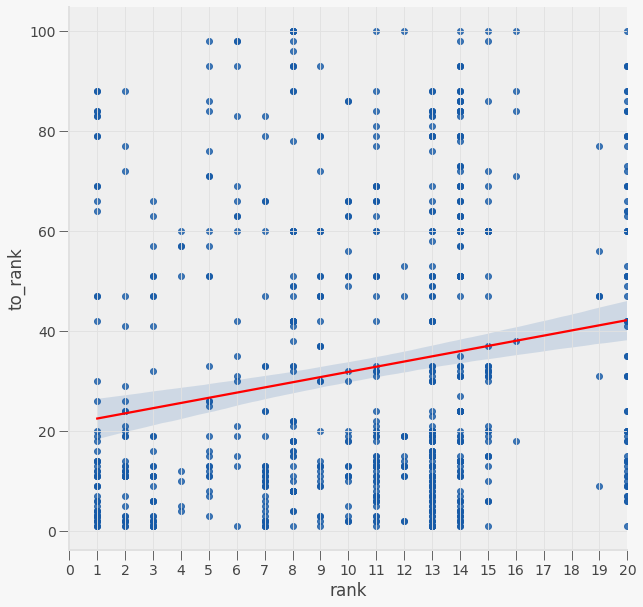

In [52]:
data_clean_rank_top_20 = data_clean_rank.loc[data_clean_rank["rank"] <= 20]
fig, ax = plt.subplots(figsize = (10, 10))
rank_scat = sns.regplot(x = "rank", y = "to_rank", data = data_clean_rank_top_20, ax = ax)
rank_scat.get_lines()[0].set_color("red")
plt.xticks(np.arange(0, 21, 1.0))
plt.show()

In [17]:
skew = pd.DataFrame(data_clean_rank.skew(), columns = ["skewness"])
kurt = pd.DataFrame(data_clean_rank.kurtosis(), columns = ["kurtosis"])
skewkurt = pd.concat([skew, kurt], axis = 1)
fulldesc = pd.concat([data_clean_rank.describe(), skewkurt.T])
fulldesc

,aid,to_institution_id,to_oid,to_latitude,to_longitude,to_rank,recruiter_type,from_oid,from_institution_id,latitude,longitude,category_id,rank,revised_recruiter_hash
count,1210.000000,1210.000000,1210.000000,1124.000000,1124.000000,1210.000000,1210.000000,1210.000000,1210.000000,1210.000000,1210.000000,1210.000000,1210.000000,1.210000e+03
mean,28022.109091,281.255372,595.200826,39.347232,-45.390382,34.437190,1.450413,333.198347,265.276033,41.339156,-59.320042,9.784298,20.584298,5.260141e+18
std,14861.038705,279.052782,700.774333,17.295089,67.780175,28.828774,1.088144,323.898202,285.827069,11.168140,49.505632,6.318190,20.640407,2.046336e+18
min,7.000000,2.000000,20.000000,-37.912641,-123.253794,1.000000,1.000000,20.000000,2.000000,-37.801380,-123.250418,1.000000,1.000000,-4.465939e+18
25%,13573.000000,73.000000,139.000000,38.983057,-83.737582,11.000000,1.000000,85.250000,17.000000,39.953339,-83.737582,6.000000,8.000000,5.719709e+18
50%,33403.000000,184.000000,361.000000,41.789922,-74.655533,24.000000,1.000000,217.000000,186.000000,41.313892,-74.655533,10.000000,14.000000,5.719709e+18
75%,41955.250000,361.000000,886.000000,47.657111,-1.194493,57.750000,1.000000,406.000000,350.000000,42.376417,-71.083557,13.000000,24.000000,5.719709e+18
max,47690.000000,1104.000000,5051.000000,59.362174,153.013491,100.000000,8.000000,1347.000000,1089.000000,59.362174,153.013491,34.000000,100.000000,8.075922e+18
skewness,-0.427576,1.229953,2.216633,-3.441758,1.396352,0.711909,3.229377,1.234817,1.066048,-4.929478,1.709218,0.706839,2.060622,-2.091724e+00
kurtosis,-1.349272,0.681526,5.764407,12.416536,1.390454,-0.766935,12.683500,0.511837,-0.019915,32.668148,3.831658,0.720395,3.873360,5.061226e+00


In [18]:
rank_1 = data_clean_rank.loc[data_clean_rank["rank"] == 1]
rank_1.describe()

,aid,to_institution_id,to_oid,to_latitude,to_longitude,to_rank,recruiter_type,from_oid,from_institution_id,latitude,longitude,category_id,rank,revised_recruiter_hash
count,57.000000,57.000000,57.000000,49.000000,49.000000,57.000000,57.000000,57.0,57.0,5.700000e+01,5.700000e+01,57.000000,57.0,5.700000e+01
mean,36689.052632,269.000000,770.087719,40.517750,-76.368236,25.210526,1.666667,406.0,350.0,4.237642e+01,-7.111827e+01,9.561404,1.0,4.821998e+18
std,8205.631262,257.394569,740.938818,6.841045,42.901225,29.569976,1.286375,0.0,0.0,4.301153e-14,1.433718e-14,6.076940,0.0,2.617506e+18
min,19366.000000,2.000000,28.000000,1.297537,-123.250418,1.000000,1.000000,406.0,350.0,4.237642e+01,-7.111827e+01,1.000000,1.0,-4.465939e+18
25%,29762.000000,78.000000,186.000000,37.873603,-87.671907,4.000000,1.000000,406.0,350.0,4.237642e+01,-7.111827e+01,6.000000,1.0,5.719709e+18
50%,38645.000000,255.000000,407.000000,41.315128,-75.196822,11.000000,1.000000,406.0,350.0,4.237642e+01,-7.111827e+01,9.000000,1.0,5.719709e+18
75%,42970.000000,350.000000,1099.000000,42.350911,-71.404386,42.000000,2.000000,406.0,350.0,4.237642e+01,-7.111827e+01,14.000000,1.0,5.719709e+18
max,47688.000000,1089.000000,3297.000000,51.526067,103.848970,88.000000,8.000000,406.0,350.0,4.237642e+01,-7.111827e+01,24.000000,1.0,8.075922e+18


In [19]:
data_clean_rank.groupby(["rank", "from_institution_name"]).count()

,,aid,to_institution_id,to_name,to_oid,startdate,to_latitude,to_longitude,to_rank,recruiter_type,description,from_oid,from_institution_id,latitude,longitude,category_id,name,desc_tokens,revised_description,revised_recruiter_hash,from_coordinates,to_coordinates
rank,from_institution_name,,,,,,,,,,,,,,,,,,,,,
1.0,Harvard University,57,57,57,57,57,49,49,57,57,57,57,57,57,57,57,57,57,57,57,57,57
2.0,University of Chicago,36,36,36,36,36,33,33,36,36,36,36,36,36,36,36,36,36,36,36,36,36
3.0,Stanford University,37,37,37,37,37,35,35,37,37,37,37,37,37,37,37,37,37,37,37,37,37
4.0,"University of California, Berkeley",8,8,8,8,8,6,6,8,8,8,8,8,8,8,8,8,8,8,8,8,8
5.0,London School of Economics and Political Science,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93.0,Stockholm School of Economics,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11
96.0,University of Queensland,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
100.0,University of Bristol,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


Text(0.5, 1.0, 'Correlation Matrix')

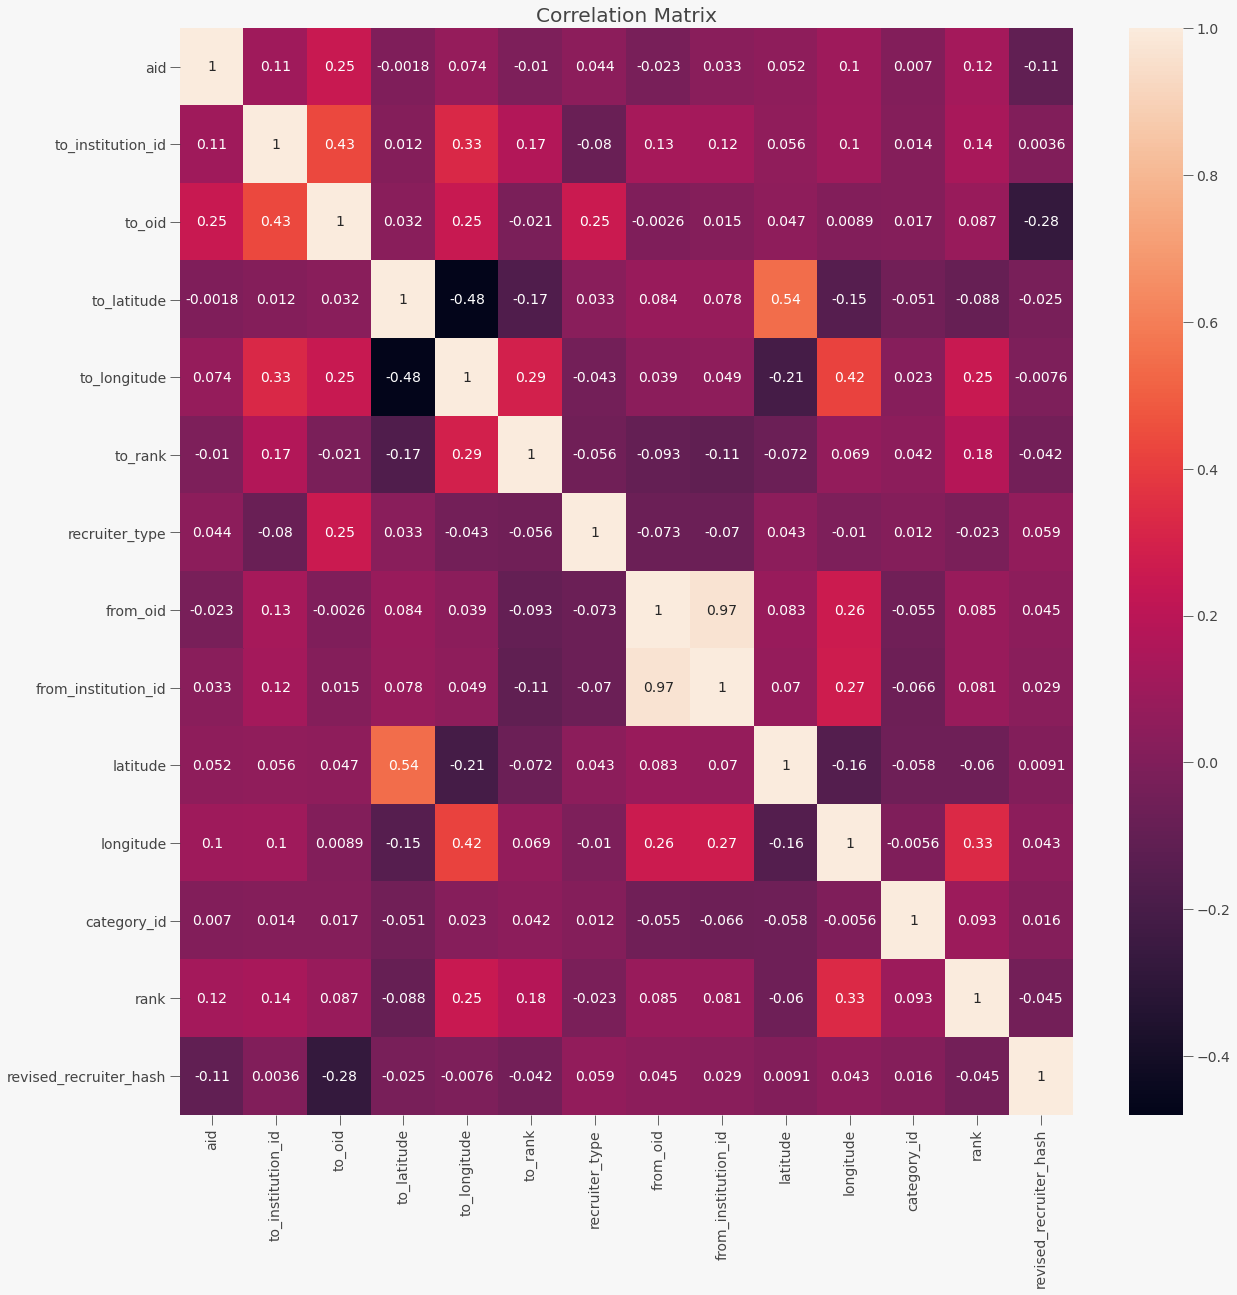

In [20]:
fig, ax = plt.subplots(figsize = (20, 20))
sns.heatmap(data_clean_rank.corr(), annot = True)
ax.set_title("Correlation Matrix")

In [21]:
torank_rank_regression = smf.ols(formula = "to_rank ~ rank", data = data_clean_rank)
torank_rank_regression = torank_rank_regression.fit()
torank_rank_regression.summary()

# simple linear regression
# using rank of institution came from to predict (explain) rank of institution ended up
# ceteris paribus, a unit decrease in the rank of the institution where the applicant graduated from is associated with a 0.2535 \pm 0.04 unit decrease in the rank of the institution where the applicant ended up which is statistically significant at a 0.01 significance level
# we would expect to see this strictly positive relationship 99 times out of 100
# the regression explains 3.2 percent of the variation in the data
# 0 rank DNE therefore intercept has no interpretation

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                to_rank   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.032
Method:                 Least Squares   F-statistic:                     41.14
Date:                Tue, 19 May 2020   Prob (F-statistic):           2.03e-10
Time:                        06:48:55   Log-Likelihood:                -5763.4
No. Observations:                1210   AIC:                         1.153e+04
Df Residuals:                    1208   BIC:                         1.154e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     29.2196      1.152     25.370      0.000      26.960      31.479
rank           0.2535      0.040      6.414      0.000       0.176       0.331
==============================================================================
Omnibus:                      132.544   Durbin-Watson:                   1.774
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              125.685
Skew:                           0.722   Prob(JB):                     5.10e-28
Kurtosis:                       2.362   Cond. No.                         41.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [22]:
data_clean_rank["log_rank"] = np.log(data_clean_rank["rank"])
data_clean_rank["log_to_rank"] = np.log(data_clean_rank["to_rank"])
torank_rank_regression = smf.ols(formula = "log_to_rank ~ log_rank", data = data_clean_rank)
torank_rank_regression = torank_rank_regression.fit(cov_type = "HC1")
torank_rank_regression.summary()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            log_to_rank   R-squared:                       0.057
Model:                            OLS   Adj. R-squared:                  0.056
Method:                 Least Squares   F-statistic:                     61.99
Date:                Tue, 19 May 2020   Prob (F-statistic):           7.64e-15
Time:                        06:48:55   Log-Likelihood:                -1859.7
No. Observations:                1210   AIC:                             3723.
Df Residuals:                    1208   BIC:                             3734.
Df Model:                           1                                         
Covariance Type:                  HC1                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.3256      0.100     23.185      0.000       2.129       2.522
log_rank       0.2758      0.035      7.873      0.000       0.207       0.344
==============================================================================
Omnibus:                       77.780   Durbin-Watson:                   1.795
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               92.047
Skew:                          -0.674   Prob(JB):                     1.03e-20
Kurtosis:                       3.081   Cond. No.                         8.58
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

In [23]:
ranking_foo_data = pd.read_json("tilberg_rankings.json") #set directory as necessary
pd.set_option('display.max_rows', ranking_foo_data.shape[0]+1)
ranking_foo_data.sort_values(by = ["rank"])


,ranking_sources_id,name,ejm_organization_id,ejm_institution_id,rank
54,1,Harvard University - Department of Economics,406,350,1
103,1,Tata Center for Development at the University ...,1275,339,2
92,1,University of Chicago Urban Labs - Urban Energ...,1076,339,2
52,1,University of Chicago - Economics,394,339,2
88,1,"Energy Policy Institute at Chicago, University...",923,339,2
21,1,Stanford University - Department of Economics,92,78,3
48,1,University of California Berkeley - Haas Schoo...,343,781,4
55,1,London School of Economics and Political Scien...,407,351,5
33,1,University of Pennsylvania - Department of Eco...,157,137,6
81,1,"Perelman School of Medicine, University of Pen...",805,137,6


In [24]:
torank_rank_regression_hc1 = smf.ols(formula = "to_rank ~ rank", data = data_clean_rank)
torank_rank_regression_hc1 = torank_rank_regression_hc1.fit(cov_type = "HC1")
torank_rank_regression_hc1.summary()

#controls for heteroscedasticity

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                to_rank   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.032
Method:                 Least Squares   F-statistic:                     35.39
Date:                Tue, 19 May 2020   Prob (F-statistic):           3.54e-09
Time:                        06:48:55   Log-Likelihood:                -5763.4
No. Observations:                1210   AIC:                         1.153e+04
Df Residuals:                    1208   BIC:                         1.154e+04
Df Model:                           1                                         
Covariance Type:                  HC1                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     29.2196      1.179     24.788      0.000      26.909      31.530
rank           0.2535      0.043      5.949      0.000       0.170       0.337
==============================================================================
Omnibus:                      132.544   Durbin-Watson:                   1.774
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              125.685
Skew:                           0.722   Prob(JB):                     5.10e-28
Kurtosis:                       2.362   Cond. No.                         41.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

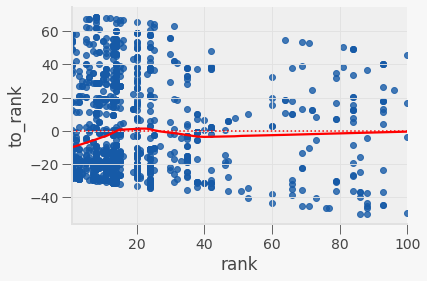

In [25]:
torank_rank_resid = sns.residplot(data_clean_rank["rank"], data_clean_rank["to_rank"], lowess=True)
torank_rank_resid.get_lines()[0].set_color("r")
torank_rank_resid.get_lines()[1].set_color("r")


Text(0.5, 0, 'fitted_values')

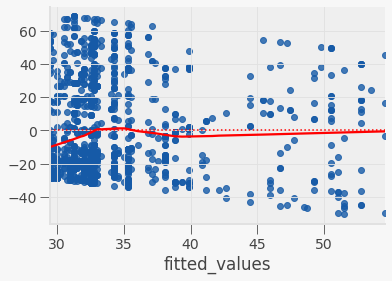

In [26]:
fig, ax = plt.subplots()
fit_resid = sns.residplot(torank_rank_regression_hc1.fittedvalues, torank_rank_regression_hc1.resid, lowess = True, ax = ax)
fit_resid.get_lines()[0].set_color("r")
fit_resid.get_lines()[1].set_color("r")
ax.set_xlabel("fitted_values")

In [27]:
st.shapiro(torank_rank_regression_hc1.resid) #tests null hypothesis that sample came from normally distributed population; if p value less than alpha, reject null i.e. evidence data tested not normally distributed

(0.9091321229934692, 2.936445048387006e-26)

In [28]:
white_test = het_white(torank_rank_regression_hc1.resid, torank_rank_regression_hc1.model.exog)
labels = ["LM Statistic", "LM-Test p-value", "F Statistic", "F-Test p-value"]
whitedict = dict(zip(labels, white_test))
whitedata = pd.DataFrame.from_dict(whitedict, orient = 'index')
whitedata = whitedata.rename(columns = {0 : "White Test Values"})
whitedata

,White Test Values
LM Statistic,5.796547
LM-Test p-value,0.055118
F Statistic,2.905004
F-Test p-value,0.055131


In [29]:
breuschpagan_test = statsmodels.stats.diagnostic.het_breuschpagan(torank_rank_regression_hc1.resid, torank_rank_regression_hc1.model.exog)
labels = ["LM Statistic", "LM-Test p-value", "F Statistic", "F-Test p-value"]
breuschpagandict = dict(zip(labels, breuschpagan_test))
breuschpagandata = pd.DataFrame.from_dict(breuschpagandict, orient = 'index')
breuschpagandata = breuschpagandata.rename(columns = {0 : "Breusch-Pagan Test Values"})
breuschpagandata

,Breusch-Pagan Test Values
LM Statistic,1.006099
LM-Test p-value,0.315839
F Statistic,1.005272
F-Test p-value,0.316239


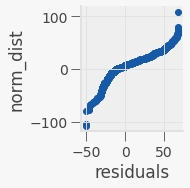

In [30]:
resid_data = pd.DataFrame(torank_rank_regression_hc1.resid)
all_data = pd.concat([data_clean_rank, resid_data], axis = 1)
all_data = all_data.rename(columns = {0: "residuals"})
sqp.qqplot(all_data, x = "residuals", y = st.norm)

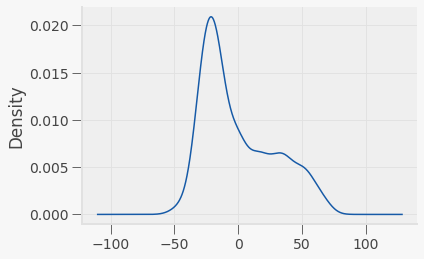

In [31]:
torank_rank_regression_hc1.resid.plot.kde()

#residuals not normally distributed; selection bias

In [0]:
#create dummies for recruiter types
data_dummies_rectype = pd.get_dummies(inst_data["revised_description"])

In [0]:
data_with_dummies = pd.concat([inst_data, data_dummies_rectype], axis = 1)

In [0]:
data_with_dummies = data_with_dummies.rename(columns = {"Government agency or commission": "govt", "Academic organization (economics department)": "econ", "Academic organization (agricultural/resource economics department)": "ag_econ", "Academic organization (business school)": "bsns", "Academic organization (other than econ, business, or ag econ)": "ac_othr", "Private business or organization; Other type of organization": "priv"})

In [35]:
data_with_dummies["academia"] = 0

for i in data_with_dummies.index:
    if data_with_dummies.econ[i] == 1 or data_with_dummies.bsns[i] == 1 or data_with_dummies.ac_othr[i] == 1 or data_with_dummies.ag_econ[i] == 1:
      data_with_dummies.academia[i] = 1
    else:
      data_with_dummies.academia[i] = 0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [36]:
from patsy import dmatrices

y_govt, X_rank = dmatrices("govt ~ rank", data_with_dummies, return_type = "dataframe")

govt_regression = sm.Logit(y_govt, X_rank)
govt_regression.fit().summary()

Optimization terminated successfully.
         Current function value: 0.247266
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   govt   No. Observations:                 3427
Model:                          Logit   Df Residuals:                     3425
Method:                           MLE   Df Model:                            1
Date:                Tue, 19 May 2020   Pseudo R-squ.:                0.001519
Time:                        06:48:57   Log-Likelihood:                -847.38
converged:                       True   LL-Null:                       -848.67
Covariance Type:            nonrobust   LLR p-value:                    0.1084
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.7419      0.102    -26.964      0.000      -2.941      -2.543
rank           0.0049      0.003      1.645      0.100      -0.001       0.011
==============================================================================
"""

In [37]:
from patsy import dmatrices

y_econ, X_rank = dmatrices("econ ~ rank", data_with_dummies, return_type = "dataframe")

econ_regression = sm.Logit(y_econ, X_rank)
econ_regression.fit().summary()

Optimization terminated successfully.
         Current function value: 0.675846
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   econ   No. Observations:                 3427
Model:                          Logit   Df Residuals:                     3425
Method:                           MLE   Df Model:                            1
Date:                Tue, 19 May 2020   Pseudo R-squ.:               0.0002129
Time:                        06:48:57   Log-Likelihood:                -2316.1
converged:                       True   LL-Null:                       -2316.6
Covariance Type:            nonrobust   LLR p-value:                    0.3206
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3355      0.052      6.477      0.000       0.234       0.437
rank           0.0016      0.002      0.991      0.322      -0.002       0.005
==============================================================================
"""

In [38]:
from patsy import dmatrices

y_academia, X_rank = dmatrices("academia ~ rank", data_with_dummies, return_type = "dataframe")

academia_regression = sm.Logit(y_academia, X_rank)
academia_regression.fit().summary()

Optimization terminated successfully.
         Current function value: 0.529936
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               academia   No. Observations:                 3427
Model:                          Logit   Df Residuals:                     3425
Method:                           MLE   Df Model:                            1
Date:                Tue, 19 May 2020   Pseudo R-squ.:               0.0005607
Time:                        06:48:57   Log-Likelihood:                -1816.1
converged:                       True   LL-Null:                       -1817.1
Covariance Type:            nonrobust   LLR p-value:                    0.1534
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.1852      0.061     19.362      0.000       1.065       1.305
rank           0.0028      0.002      1.412      0.158      -0.001       0.007
==============================================================================
"""

In [39]:
from patsy import dmatrices

y_priv, X_rank = dmatrices("priv ~ rank", data_with_dummies, return_type = "dataframe")

priv_regression = sm.Logit(y_priv, X_rank)
priv_regression.fit().summary()

Optimization terminated successfully.
         Current function value: 0.430005
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   priv   No. Observations:                 3427
Model:                          Logit   Df Residuals:                     3425
Method:                           MLE   Df Model:                            1
Date:                Tue, 19 May 2020   Pseudo R-squ.:                0.002755
Time:                        06:48:57   Log-Likelihood:                -1473.6
converged:                       True   LL-Null:                       -1477.7
Covariance Type:            nonrobust   LLR p-value:                  0.004326
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.5449      0.071    -21.869      0.000      -1.683      -1.406
rank          -0.0067      0.002     -2.759      0.006      -0.012      -0.002
==============================================================================
"""

In [0]:
import string 

#create dummies for applicants primary fields
#dummy variable trap
data_dummies_appfie = pd.get_dummies(inst_data["name"], drop_first = True)

#rename columns that may cause issues with regression
foo = pd.Series(data_dummies_appfie.columns.str.lower())

for i in foo.index:
  foo[i] = foo[i].translate(str.maketrans("", "", string.punctuation)) #strips punctutation
  foo[i] = foo[i].replace(" ", "_") #replace space with underscore

appfie_col = pd.Series(data_dummies_appfie.columns)
appfie_dict = pd.concat([foo, appfie_col], axis = 1)
appfie_dict = dict(zip(appfie_dict[1], appfie_dict[0]))

data_dummies_appfie = data_dummies_appfie.rename(columns = appfie_dict)


In [41]:
app_fields_ser = pd.Series(foo)
app_fields_ser.str.cat(sep=" + ")

'any_field + behavioral_economics + business_economics + computational_economics + decision_sciences + development_growth + econometrics + economic_history + environmental_ag_econ + experimental_economics + finance + health_education_welfare + industrial_organization + insurance + international_financemacro + international_trade + labor_demographic_economics + law_and_economics + macroeconomics_monetary + management_general + management_information_technology + marketing + microeconomics + operations_research + organizational_behavior + other + political_economy + public_economics + real_estate + statistics + theory + urban_rural_regional_economics'

In [42]:
data_with_dummies = pd.concat([inst_data, data_dummies_rectype, data_dummies_appfie], axis = 1)
data_with_dummies = data_with_dummies.rename(columns = {"Government agency or commission": "govt", "Academic organization (economics department)": "econ", "Academic organization (agricultural/resource economics department)": "ag_econ", "Academic organization (business school)": "bsns", "Academic organization (other than econ, business, or ag econ)": "ac_othr", "Private business or organization; Other type of organization": "priv"})

data_with_dummies["academia"] = 0

for i in data_with_dummies.index:
    if data_with_dummies.econ[i] == 1 or data_with_dummies.bsns[i] == 1 or data_with_dummies.ac_othr[i] == 1 or data_with_dummies.ag_econ[i] == 1:
      data_with_dummies.academia[i] = 1
    else:
      data_with_dummies.academia[i] = 0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [43]:
from patsy import dmatrices

y_govt, X_rank = dmatrices("govt ~ rank + " + app_fields_ser.str.cat(sep=" + "), data_with_dummies, return_type = "dataframe")

govt_regression = sm.Logit(y_govt, X_rank)
govt_regression.fit(method = "ncg").summary() #arbitrary choice of solver

#a unit increase in x_i increases the log odds of (the event that govt = 1) the applicant moved to the government by \beta_i

Optimization terminated successfully.
         Current function value: 0.230289
         Iterations: 18
         Function evaluations: 26
         Gradient evaluations: 43
         Hessian evaluations: 18


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   govt   No. Observations:                 3427
Model:                          Logit   Df Residuals:                     3393
Method:                           MLE   Df Model:                           33
Date:                Tue, 19 May 2020   Pseudo R-squ.:                 0.07007
Time:                        06:48:58   Log-Likelihood:                -789.20
converged:                       True   LL-Null:                       -848.67
Covariance Type:            nonrobust   LLR p-value:                 1.221e-11
=====================================================================================================
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                            -3.3427      1.179     -2.835      0.005      -5.654      -1.031
rank                                  0.0053      0.003      1.755      0.079      -0.001       0.011
any_field                            -1.5204      1.873     -0.812      0.417      -5.191       2.150
behavioral_economics                 -1.0943      1.527     -0.717      0.474      -4.087       1.898
business_economics                    0.1785      1.634      0.109      0.913      -3.023       3.380
computational_economics              -0.0836      5.521     -0.015      0.988     -10.904      10.737
decision_sciences                    -0.3525      2.989     -0.118      0.906      -6.211       5.506
development_growth                   -0.2204      1.223     -0.180      0.857      -2.617       2.176
econometrics                         -0.4264      1.249     -0.342      0.733      -2.874       2.021
economic_history                     -0.5956      1.558     -0.382      0.702      -3.650       2.459
environmental_ag_econ                 0.3400      1.230      0.276      0.782      -2.070       2.750
experimental_economics               -0.8770      1.540     -0.570      0.569      -3.895       2.141
finance                               0.9250      1.191      0.777      0.437      -1.409       3.259
health_education_welfare              0.3166      1.238      0.256      0.798      -2.110       2.743
industrial_organization               0.8263      1.202      0.688      0.492      -1.529       3.181
insurance                            -0.1693      4.023     -0.042      0.966      -8.054       7.715
international_financemacro            1.1208      1.207      0.928      0.353      -1.245       3.487
international_trade                  -0.0340      1.238     -0.027      0.978      -2.460       2.392
labor_demographic_economics           0.4727      1.196      0.395      0.693      -1.871       2.816
law_and_economics                     1.9560      1.365      1.433      0.152      -0.719       4.631
macroeconomics_monetary               1.5558      1.183      1.315      0.188      -0.763       3.875
management_general                   -0.8281      2.237     -0.370      0.711      -5.213       3.557
management_information_technology    -0.0798      5.644     -0.014      0.989     -11.142      10.983
marketing                            -0.2385      3.484     -0.068      0.945      -7.068       6.591
microeconomics                        0.2049      1.211      0.169      0.866      -2.169       2.579
operations_research                  -0.2260      3.562     -0.063      0.949      -7.207       6.755
organizational_behavior              -0.1531      4.206     -0.036      0.971      -8.398       8.091
other                                -0.3496      2.999     -0.117      0.907      -6.227       5.528
political_economy                    -0.8255      1.542     -0.535      0.592  

In [44]:
from patsy import dmatrices

y_econ, X_rank = dmatrices("econ ~ rank + " + app_fields_ser.str.cat(sep=" + "), data_with_dummies, return_type = "dataframe")

econ_regression = sm.Logit(y_econ, X_rank)
econ_regression.fit(method = "ncg").summary() #arbitrary choice of solver

Optimization terminated successfully.
         Current function value: 0.653949
         Iterations: 13
         Function evaluations: 14
         Gradient evaluations: 26
         Hessian evaluations: 13


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   econ   No. Observations:                 3427
Model:                          Logit   Df Residuals:                     3393
Method:                           MLE   Df Model:                           33
Date:                Tue, 19 May 2020   Pseudo R-squ.:                 0.03261
Time:                        06:48:58   Log-Likelihood:                -2241.1
converged:                       True   LL-Null:                       -2316.6
Covariance Type:            nonrobust   LLR p-value:                 4.893e-17
=====================================================================================================
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                            -0.5709      0.478     -1.194      0.232      -1.508       0.366
rank                                  0.0011      0.002      0.673      0.501      -0.002       0.004
any_field                             1.2248      0.561      2.184      0.029       0.126       2.324
behavioral_economics                  1.5365      0.540      2.846      0.004       0.479       2.595
business_economics                    1.2404      0.690      1.797      0.072      -0.112       2.593
computational_economics               8.4527     52.198      0.162      0.871     -93.854     110.760
decision_sciences                     1.9320      1.215      1.590      0.112      -0.449       4.313
development_growth                    0.9880      0.490      2.015      0.044       0.027       1.949
econometrics                          1.8828      0.504      3.738      0.000       0.896       2.870
economic_history                      1.4103      0.573      2.461      0.014       0.287       2.534
environmental_ag_econ                 0.7563      0.503      1.503      0.133      -0.230       1.743
experimental_economics                1.6600      0.561      2.959      0.003       0.561       2.759
finance                               0.2963      0.488      0.607      0.544      -0.661       1.254
health_education_welfare              0.8012      0.507      1.580      0.114      -0.193       1.795
industrial_organization               0.7166      0.496      1.446      0.148      -0.255       1.688
insurance                            -8.0740     52.205     -0.155      0.877    -110.393      94.245
international_financemacro            0.7514      0.506      1.484      0.138      -0.241       1.744
international_trade                   1.1283      0.500      2.256      0.024       0.148       2.109
labor_demographic_economics           0.9599      0.487      1.970      0.049       0.005       1.915
law_and_economics                     1.6395      0.819      2.002      0.045       0.034       3.245
macroeconomics_monetary               0.5576      0.486      1.148      0.251      -0.394       1.510
management_general                    0.7921      0.693      1.143      0.253      -0.566       2.150
management_information_technology    -7.3545     52.201     -0.141      0.888    -109.666      94.957
marketing                             1.2275      1.314      0.934      0.350      -1.348       3.803
microeconomics                        1.2207      0.493      2.474      0.013       0.254       2.188
operations_research                  -0.1451      1.314     -0.110      0.912      -2.720       2.430
organizational_behavior               9.1578     52.202      0.175      0.861     -93.156     111.472
other                                 0.1425      1.029      0.138      0.890      -1.875       2.160
political_economy                     1.1954      0.547      2.185      0.029  

In [45]:
from patsy import dmatrices

y_academia, X_rank = dmatrices("academia ~ rank + " + app_fields_ser.str.cat(sep=" + "), data_with_dummies, return_type = "dataframe")

academia_regression = sm.Logit(y_academia, X_rank)
academia_regression.fit(method = "ncg").summary() #arbitrary choice of solver

Optimization terminated successfully.
         Current function value: 0.508114
         Iterations: 19
         Function evaluations: 24
         Gradient evaluations: 42
         Hessian evaluations: 19


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               academia   No. Observations:                 3427
Model:                          Logit   Df Residuals:                     3393
Method:                           MLE   Df Model:                           33
Date:                Tue, 19 May 2020   Pseudo R-squ.:                 0.04172
Time:                        06:48:59   Log-Likelihood:                -1741.3
converged:                       True   LL-Null:                       -1817.1
Covariance Type:            nonrobust   LLR p-value:                 3.942e-17
=====================================================================================================
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                             2.8182      1.029      2.739      0.006       0.802       4.835
rank                                  0.0027      0.002      1.302      0.193      -0.001       0.007
any_field                            -1.2262      1.097     -1.117      0.264      -3.377       0.925
behavioral_economics                 -0.7250      1.093     -0.663      0.507      -2.868       1.418
business_economics                   -0.7933      1.272     -0.624      0.533      -3.287       1.700
computational_economics               5.6216     70.266      0.080      0.936    -132.098     143.341
decision_sciences                     7.2373     70.270      0.103      0.918    -130.490     144.965
development_growth                   -1.6367      1.037     -1.579      0.114      -3.669       0.395
econometrics                         -0.8228      1.049     -0.784      0.433      -2.879       1.234
economic_history                     -0.9380      1.117     -0.840      0.401      -3.127       1.251
environmental_ag_econ                -1.7680      1.045     -1.692      0.091      -3.816       0.280
experimental_economics               -0.6749      1.114     -0.606      0.545      -2.858       1.508
finance                              -1.6143      1.036     -1.558      0.119      -3.645       0.416
health_education_welfare             -1.8799      1.046     -1.797      0.072      -3.931       0.171
industrial_organization              -1.7837      1.040     -1.715      0.086      -3.822       0.254
insurance                             6.2818     70.269      0.089      0.929    -131.443     144.006
international_financemacro           -2.3352      1.043     -2.239      0.025      -4.380      -0.291
international_trade                  -1.0964      1.049     -1.045      0.296      -3.153       0.960
labor_demographic_economics          -1.6600      1.035     -1.604      0.109      -3.688       0.369
law_and_economics                    -1.7891      1.225     -1.461      0.144      -4.190       0.612
macroeconomics_monetary              -2.3341      1.033     -2.260      0.024      -4.358      -0.310
management_general                   -0.1793      1.457     -0.123      0.902      -3.035       2.676
management_information_technology     5.6484     70.266      0.080      0.936    -132.071     143.368
marketing                             6.6995     70.270      0.095      0.924    -131.027     144.426
microeconomics                       -1.3626      1.040     -1.310      0.190      -3.401       0.676
operations_research                   6.7313     70.270      0.096      0.924    -130.995     144.457
organizational_behavior               6.3419     70.269      0.090      0.928    -131.383     144.066
other                                -1.4851      1.519     -0.978      0.328      -4.461       1.491
political_economy                    -0.9732      1.095     -0.888      0.374  

In [46]:
from patsy import dmatrices

y_priv, X_rank = dmatrices("priv ~ rank + " + app_fields_ser.str.cat(sep=" + "), data_with_dummies, return_type = "dataframe")

priv_regression = sm.Logit(y_priv, X_rank)
priv_regression.fit(method = "ncg").summary() #arbitrary choice of solver

Optimization terminated successfully.
         Current function value: 0.419119
         Iterations: 28
         Function evaluations: 34
         Gradient evaluations: 61
         Hessian evaluations: 28


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   priv   No. Observations:                 3427
Model:                          Logit   Df Residuals:                     3393
Method:                           MLE   Df Model:                           33
Date:                Tue, 19 May 2020   Pseudo R-squ.:                 0.02800
Time:                        06:48:59   Log-Likelihood:                -1436.3
converged:                       True   LL-Null:                       -1477.7
Covariance Type:            nonrobust   LLR p-value:                 3.705e-06
=====================================================================================================
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                            -2.7115      1.030     -2.633      0.008      -4.730      -0.693
rank                                 -0.0069      0.002     -2.770      0.006      -0.012      -0.002
any_field                             1.2534      1.098      1.141      0.254      -0.899       3.406
behavioral_economics                  0.5858      1.102      0.532      0.595      -1.574       2.745
business_economics                    0.0149      1.455      0.010      0.992      -2.837       2.866
computational_economics              -5.4026     62.817     -0.086      0.931    -128.522     117.716
decision_sciences                    -7.0292     62.821     -0.112      0.911    -130.157     116.099
development_growth                    1.4260      1.038      1.373      0.170      -0.609       3.461
econometrics                          0.5149      1.056      0.488      0.626      -1.554       2.584
economic_history                      0.6888      1.132      0.608      0.543      -1.530       2.907
environmental_ag_econ                 1.4503      1.049      1.383      0.167      -0.605       3.506
experimental_economics                0.4767      1.129      0.422      0.673      -1.736       2.690
finance                               0.9554      1.041      0.918      0.359      -1.085       2.996
health_education_welfare              1.5864      1.050      1.511      0.131      -0.472       3.644
industrial_organization               1.2394      1.045      1.186      0.236      -0.809       3.288
insurance                            -6.0106     62.820     -0.096      0.924    -129.135     117.114
international_financemacro            1.8039      1.047      1.723      0.085      -0.248       3.856
international_trade                   0.7379      1.056      0.699      0.485      -1.332       2.808
labor_demographic_economics           1.2493      1.037      1.204      0.229      -0.784       3.283
law_and_economics                    -7.8796     62.822     -0.125      0.900    -131.008     115.249
macroeconomics_monetary               1.5149      1.035      1.463      0.143      -0.514       3.544
management_general                    0.1776      1.458      0.122      0.903      -2.679       3.034
management_information_technology    -5.4716     62.817     -0.087      0.931    -128.591     117.647
marketing                            -6.4482     62.821     -0.103      0.918    -129.575     116.678
microeconomics                        0.9966      1.044      0.955      0.340      -1.050       3.043
operations_research                  -6.5293     62.821     -0.104      0.917    -129.656     116.597
organizational_behavior              -6.1659     62.820     -0.098      0.922    -129.290     116.959
other                                 1.4615      1.519      0.962      0.336      -1.516       4.439
political_economy                     0.7845      1.104      0.711      0.477  